# Endoscopy Access Visualisation by LSOA

This notebook visualises spatial access to endoscopy services across the South West region, focusing on population aged 50 and over, and capacity measured as endoscopy rooms per 100,000 people.

1. Load spatial population data (age 50+) and endoscopy site capacity data (CDC, Acute, and optionally Community Hospitals)
2. Classify and visualise each site’s access level using thresholds:
   - Under 3.5 rooms per 100k aged 50+ → Low access
   - 3.5 to 3.9 rooms → Marginal access
   - 4.0 and above → Adequate access
3. Visualise 50+ population distribution as a choropleth map
4. Overlay travel time bands and site locations to assess geographic inequalities
5. Prepare a base for incorporating LSOA-to-LSOA travel time matrices for accessibility scoring, catchment analysis, and future scenario testing (e.g., new room or site additions)


In [1]:
# ----------------------------------------------------------
# Step 0 – Imports, File Paths, and Script Path Setup
# ----------------------------------------------------------
import os
import sys
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Optional for warnings
import warnings
warnings.filterwarnings("ignore")

# Add custom script directory if needed
script_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/scripts"
if script_dir not in sys.path:
    sys.path.append(script_dir)

# Define base data directory
data_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw"
modality_dir = os.path.join(data_dir, "modality_modelling")

# File paths
gpkg_path = os.path.join(data_dir, "LSOA_5-year_segment_master.gpkg")
travel_csv_path = os.path.join(data_dir, "LSOA_to_LSOA_complete.csv")
modality_counts_path = os.path.join(data_dir, "modality_procedure_counts_by_age_band_2024.csv")
cdc_path = os.path.join(modality_dir, "NHS_SW_ Community_Diagnostic_Centres_Capability.csv")
acute_path = os.path.join(modality_dir, "NHS_SW_Acute_Hospitals_Capability.csv")

# Placeholder for community hospital file
# community_path = os.path.join(modality_dir, "NHS_SW_Community_Hospitals_Capability.csv")  # To be added


In [2]:
# ----------------------------------------------------------
# Step 1 – Load and Prepare Travel Matrix, Facilities, and Population
# ----------------------------------------------------------

# Load travel matrix
travel_df = pd.read_csv(travel_csv_path).rename(columns={
    "origin_name": "origin_lsoa",
    "destination_name": "dest_lsoa",
    "travel_time_car": "car_travel_minutes",
    "travel_time_pt_peak": "pt_peak_minutes",
    "travel_time_pt_nonpeak": "pt_nonpeak_minutes"
})

# Clean travel matrix
travel_df["car_travel_minutes"] = pd.to_numeric(travel_df["car_travel_minutes"], errors="coerce")
travel_df["origin_lsoa"] = travel_df["origin_lsoa"].astype(str)
travel_df["dest_lsoa"] = travel_df["dest_lsoa"].astype(str)

# Load LSOA population data
gdf_pop = gpd.read_file(gpkg_path)
gdf_pop["lsoa21cd"] = gdf_pop["lsoa21cd"].astype(str)

# Compute population aged 50+
gdf_pop["population_50_plus"] = gdf_pop[[
    "age_50_54", "age_55_59", "age_60_64", "age_65_69",
    "age_70_74", "age_75_79", "age_80_84", "age_85_plus"
]].sum(axis=1)

# Load CDC and Acute hospital data
cdc_df = pd.read_csv(cdc_path)
acute_df = pd.read_csv(acute_path)

# Standardise facility data
facility_cols = ["Name", "lsoa21cd", "Endoscopy Rooms"]
cdc_df = cdc_df[facility_cols].assign(facility_type="CDC")
acute_df = acute_df[facility_cols].assign(facility_type="Acute")

# Combine facilities and drop missing LSOAs or 0-room entries
facilities_df = pd.concat([cdc_df, acute_df], ignore_index=True)
facilities_df = facilities_df.dropna(subset=["lsoa21cd"])
facilities_df = facilities_df[facilities_df["Endoscopy Rooms"] > 0].copy()
facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)


In [4]:
# ----------------------------------------------------------
# Step 2 – Build Clean Travel, Facility, and Population DataFrames
# ----------------------------------------------------------

# --- 2.1: Travel Times ---
travel_df = pd.read_csv(travel_csv_path)

# Clean column names and types
travel_df = travel_df.rename(columns={
    "origin_name": "origin_lsoa",
    "destination_name": "dest_lsoa",
    "travel_time_car": "car_travel_minutes",
    "travel_time_pt_peak": "pt_peak_minutes",
    "travel_time_pt_nonpeak": "pt_nonpeak_minutes"
})
travel_df["origin_lsoa"] = travel_df["origin_lsoa"].astype(str)
travel_df["dest_lsoa"] = travel_df["dest_lsoa"].astype(str)

# Keep relevant columns
travel_df = travel_df[[
    "origin_lsoa", "dest_lsoa", "car_travel_minutes",
    "pt_peak_minutes", "pt_nonpeak_minutes"
]].copy()

# --- 2.2: Facility Locations (CDC + Acute) ---
cdc_df = pd.read_csv(cdc_path)
acute_df = pd.read_csv(acute_path)

# Standardise and combine
facilities_df = pd.concat([
    cdc_df.assign(facility_type="CDC"),
    acute_df.assign(facility_type="Acute")
], ignore_index=True)

# Clean and keep only relevant facility rows
facilities_df = facilities_df.dropna(subset=["lsoa21cd", "Endoscopy Rooms"])
facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

# Final facility fields
facilities_df = facilities_df[[
    "Name", "lsoa21cd", "Endoscopy Rooms", "facility_type"
]].drop_duplicates()

# --- 2.3: Population 50+ per LSOA ---
# Load geospatial population data
gdf_pop = gpd.read_file(gpkg_path)

# Sum all age bands 50+
gdf_pop["population_50_plus"] = gdf_pop[
    ["age_50_54", "age_55_59", "age_60_64", "age_65_69",
     "age_70_74", "age_75_79", "age_80_84", "age_85_plus"]
].sum(axis=1)

# Extract for merging
population_df = gdf_pop[["lsoa21cd", "population_50_plus"]].copy()
population_df = population_df.rename(columns={"lsoa21cd": "origin_lsoa"})
population_df["origin_lsoa"] = population_df["origin_lsoa"].astype(str)

# Preview samples
print("\n--- travel_df sample ---")
display(travel_df.head())

print("\n--- facilities_df sample ---")
display(facilities_df.head())

print("\n--- population_df sample ---")
display(population_df.head())



--- travel_df sample ---


,origin_lsoa,dest_lsoa,car_travel_minutes,pt_peak_minutes,pt_nonpeak_minutes
0,E01022150,E01014950,42.748168,56.288168,56.288168
1,E01029238,E01033364,85.033922,126.483922,126.483922
2,E01014654,E01015202,123.315531,148.025531,146.985531
3,E01015028,E01029066,133.568645,268.518645,255.878645
4,E01015316,E01029066,112.233260,221.623260,227.623260



--- facilities_df sample ---


,Name,lsoa21cd,Endoscopy Rooms,facility_type
0,Bsw Banes Locality CDC,E01014444,3,CDC
1,Salisbury CDC,E01032014,0,CDC
2,West Swindon CDC,E01015569,0,CDC
3,Weston CDC,E01014833,0,CDC
4,North Bristol CDC,E01014861,3,CDC



--- population_df sample ---


,origin_lsoa,population_50_plus
0,E01020484,764.21
1,E01020481,893.46
2,E01020482,805.95
3,E01020479,789.67
4,E01020478,652.28


In [7]:
# ----------------------------------------------------------
# Step 3 – Classify Each LSOA by Number of Endoscopy Rooms Within Travel Bands
# ----------------------------------------------------------

# ----------------------------------------------------------
# 3A – Merge Travel, Facility, and Population Data
# ----------------------------------------------------------

# Merge travel matrix with facilities (each row = LSOA–facility pair)
travel_facility_df = travel_df.merge(
    facilities_df,
    left_on="dest_lsoa",
    right_on="lsoa21cd",
    how="inner"
)

# Merge in population data
travel_facility_df = travel_facility_df.merge(
    population_df,
    on="origin_lsoa",
    how="left"
)

# Filter out records with 0 or missing endoscopy rooms
travel_facility_df = travel_facility_df[travel_facility_df["Endoscopy Rooms"] > 0].copy()

# ----------------------------------------------------------
# 3B – Assign Travel Time Bands (Car and PT)
# ----------------------------------------------------------

# Updated car travel bands
def assign_car_band(x):
    if pd.isna(x):
        return None
    elif x < 20:
        return "A. Under 20 mins"
    elif x <= 40:
        return "B. 20–40 mins"
    else:
        return "C. Over 40 mins"

travel_facility_df["car_band"] = travel_facility_df["car_travel_minutes"].apply(assign_car_band)

# PT bands
def assign_pt_band(val):
    if pd.isna(val):
        return None
    elif val <= 25:
        return "Very Good"
    elif val <= 40:
        return "Good"
    elif val <= 60:
        return "Moderate"
    elif val <= 90:
        return "Poor"
    else:
        return "Very Poor"

travel_facility_df["pt_peak_band"] = travel_facility_df["pt_peak_minutes"].apply(assign_pt_band)
travel_facility_df["pt_nonpeak_band"] = travel_facility_df["pt_nonpeak_minutes"].apply(assign_pt_band)

# ----------------------------------------------------------
# 3C – Sum Endoscopy Rooms per Origin LSOA per Car Band
# ----------------------------------------------------------

agg_access_df = (
    travel_facility_df
    .groupby(["origin_lsoa", "car_band"])
    .agg({
        "Endoscopy Rooms": "sum",
        "population_50_plus": "first"  # constant per origin LSOA
    })
    .reset_index()
)

# Calculate rooms per 100,000 aged 50+
agg_access_df["rooms_per_100k_50plus"] = (
    agg_access_df["Endoscopy Rooms"] / agg_access_df["population_50_plus"] * 100000
)

# ----------------------------------------------------------
# 3D – Classify Access Tier
# ----------------------------------------------------------

def classify_access(val):
    if pd.isna(val):
        return None
    elif val < 3.5:
        return "Low"
    elif val < 4.0:
        return "Marginal"
    else:
        return "Adequate"

agg_access_df["access_tier"] = agg_access_df["rooms_per_100k_50plus"].apply(classify_access)

# ----------------------------------------------------------
# Preview Result
# ----------------------------------------------------------

print("\n--- Endoscopy Access Classification by LSOA and Car Travel Band ---")
display(agg_access_df.head(10))



--- Endoscopy Access Classification by LSOA and Car Travel Band ---


,origin_lsoa,car_band,Endoscopy Rooms,population_50_plus,rooms_per_100k_50plus,access_tier
0,E01014014,B. 20–40 mins,4,1034.90,386.510774,Adequate
1,E01014014,C. Over 40 mins,52,1034.90,5024.640062,Adequate
2,E01014031,C. Over 40 mins,56,914.82,6121.422794,Adequate
3,E01014032,B. 20–40 mins,2,903.64,221.327077,Adequate
4,E01014032,C. Over 40 mins,54,903.64,5975.831083,Adequate
5,E01014036,B. 20–40 mins,4,998.26,400.697213,Adequate
6,E01014036,C. Over 40 mins,52,998.26,5209.063771,Adequate
7,E01014057,B. 20–40 mins,4,1044.06,383.119744,Adequate
8,E01014057,C. Over 40 mins,52,1044.06,4980.556673,Adequate
9,E01014370,A. Under 20 mins,4,702.15,569.678844,Adequate


In [14]:
# ----------------------------------------------------------
# Create GeoDataFrames for CDC and Acute Site Locations
# ----------------------------------------------------------
from shapely.geometry import Point

# Convert to geometry using correct column names
cdc_df["geometry"] = cdc_df.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
acute_df["geometry"] = acute_df.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)

# Convert to GeoDataFrames
cdc_gdf = gpd.GeoDataFrame(cdc_df, geometry="geometry", crs="EPSG:4326")
acute_gdf = gpd.GeoDataFrame(acute_df, geometry="geometry", crs="EPSG:4326")


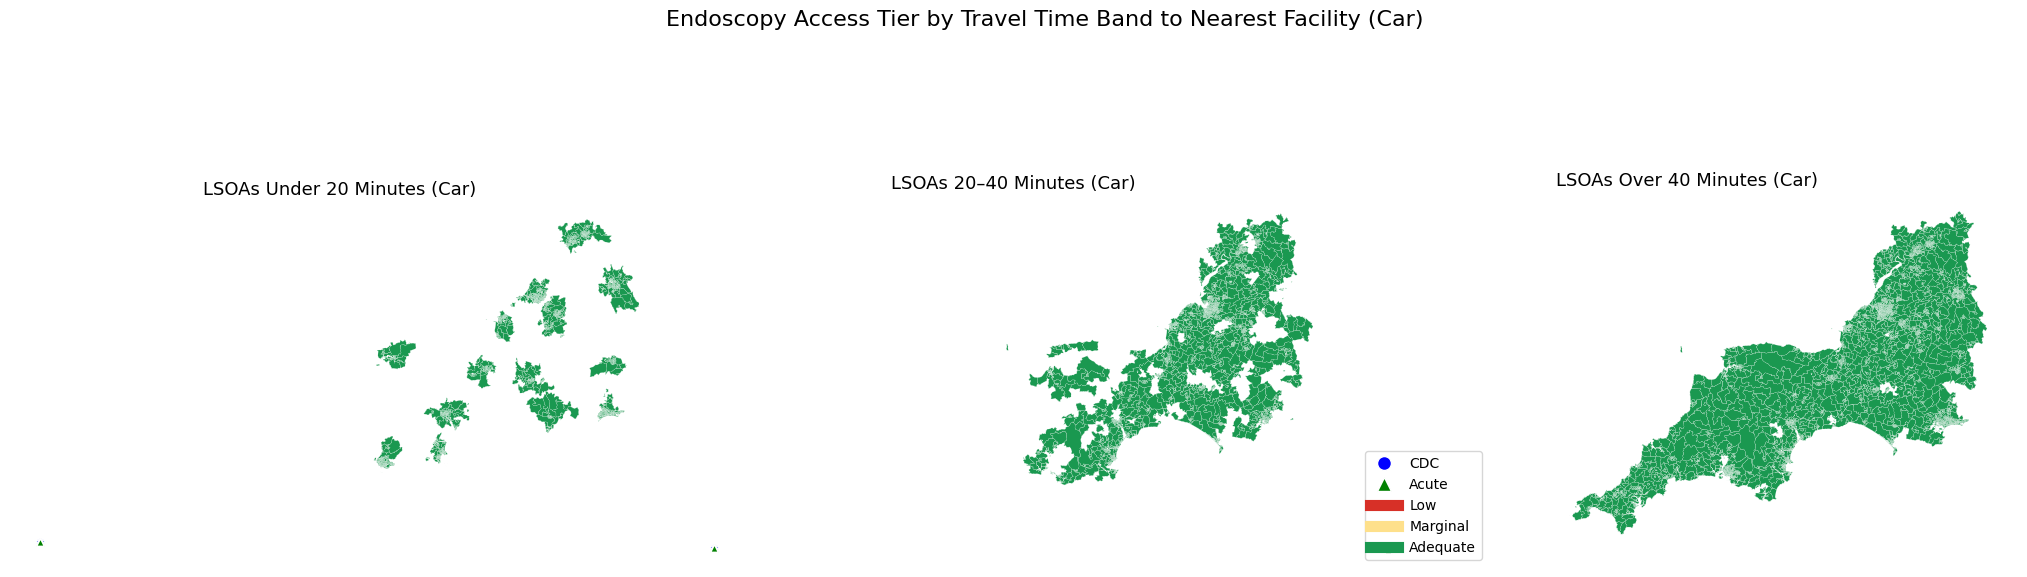

In [15]:
# ----------------------------------------------------------
# Step 4 – Visualise Endoscopy Access Tier by Car Travel Time Band
# ----------------------------------------------------------

# Reload GeoDataFrame
gdf_ct = gpd.read_file(gpkg_path)

# Ensure IDs are string
gdf_ct["lsoa21cd"] = gdf_ct["lsoa21cd"].astype(str)
agg_access_df["origin_lsoa"] = agg_access_df["origin_lsoa"].astype(str)

# Merge access classification
gdf_ct = gdf_ct.merge(
    agg_access_df[["origin_lsoa", "car_band", "access_tier"]],
    left_on="lsoa21cd",
    right_on="origin_lsoa",
    how="left"
)

# Assign colours manually
colour_map = {
    "Low": "#d73027",       # red
    "Marginal": "#fee08b",  # amber
    "Adequate": "#1a9850"   # green
}
gdf_ct["colour"] = gdf_ct["access_tier"].map(colour_map)

# Define travel time bands
lt_20 = gdf_ct[gdf_ct["car_band"] == "A. Under 20 mins"].copy()
btw_20_40 = gdf_ct[gdf_ct["car_band"] == "B. 20–40 mins"].copy()
gt_40 = gdf_ct[gdf_ct["car_band"] == "C. Over 40 mins"].copy()

# Plotting function
def plot_access_map(ax, gdf, title):
    gdf.plot(
        ax=ax,
        color=gdf["colour"],
        edgecolor="white",
        linewidth=0.1
    )
    cdc_gdf.plot(ax=ax, color="blue", markersize=30, marker="o", edgecolor="white", label="CDC")
    acute_gdf.plot(ax=ax, color="green", markersize=30, marker="^", edgecolor="white", label="Acute")
    ax.set_title(title, fontsize=13)
    ax.axis("off")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
plot_access_map(axes[0], lt_20, "LSOAs Under 20 Minutes (Car)")
plot_access_map(axes[1], btw_20_40, "LSOAs 20–40 Minutes (Car)")
plot_access_map(axes[2], gt_40, "LSOAs Over 40 Minutes (Car)")

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='CDC', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='^', color='w', label='Acute', markerfacecolor='green', markersize=10),
    Line2D([0], [0], color="#d73027", lw=8, label="Low"),
    Line2D([0], [0], color="#fee08b", lw=8, label="Marginal"),
    Line2D([0], [0], color="#1a9850", lw=8, label="Adequate")
]
axes[2].legend(handles=legend_elements, loc='lower left')

# Final layout
plt.suptitle("Endoscopy Access Tier by Travel Time Band to Nearest Facility (Car)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.97, 0.95])
plt.show()
